Downloading Dataset from OpenML


In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd


titanic = fetch_openml("titanic", version=1)

titanic_df = pd.DataFrame(data=titanic.data, columns=titanic.feature_names)
titanic_df["target"] = titanic.target



c:\Users\User\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dropping all string columns which no affect on target value


In [2]:
titanic_df['boat_presence'] = titanic_df['boat'].notna().astype(int)
titanic_df= titanic_df.drop('boat',axis=1)
columns_to_drop = ['body', 'home.dest', 'name', 'cabin', 'ticket']
titanic_df = titanic_df.drop(columns_to_drop, axis=1)



In [3]:
titanic_df.head()

,pclass,sex,age,sibsp,parch,fare,embarked,target,boat_presence
0,1.0,female,29.0000,0.0,0.0,211.3375,S,1,1
1,1.0,male,0.9167,1.0,2.0,151.5500,S,1,1
2,1.0,female,2.0000,1.0,2.0,151.5500,S,0,0
3,1.0,male,30.0000,1.0,2.0,151.5500,S,0,0
4,1.0,female,25.0000,1.0,2.0,151.5500,S,0,0


Defining a custom transformer that does all the pre-processing we need for e.g:
1) Replacing missing values of 'age' and 'fare' with the median
2) Replacing missing values of 'sex' and 'embarked' with its mode and then one-hot encoding it

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline



preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), ['age', 'fare']),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  
            ('onehot', OneHotEncoder(sparse=False)) 
        ]), ['sex', 'embarked'])
    ],
    remainder='passthrough' 
)





Splitting data into train and test

In [5]:
from sklearn.model_selection import train_test_split

X = titanic_df.drop('target', axis=1)
Y = titanic_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


Defining our Pipeline 

In [6]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC




pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()), 
    ('classifier', SVC(gamma='scale'))  
])


Applying GridSearchCV to our Pipeline to train it optimally

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
   'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
   'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}


grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
best = grid_search.best_estimator_
y_pred = best.predict(X_test)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `spa

Best Hyperparameters: {'classifier__C': 0.001, 'classifier__kernel': 'linear'}


c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Checking accuracy of our model

In [8]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)


Accuracy: 0.9732824427480916
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       144
           1       1.00      0.94      0.97       118

    accuracy                           0.97       262
   macro avg       0.98      0.97      0.97       262
weighted avg       0.97      0.97      0.97       262



Plotting Decision Boundary with PCA


c:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\AppData\Local\Temp\ipykernel_17932\1349983358.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  disp.ax_.scatter(X_train_pca[:, 0], X_train_pca[:, 1],


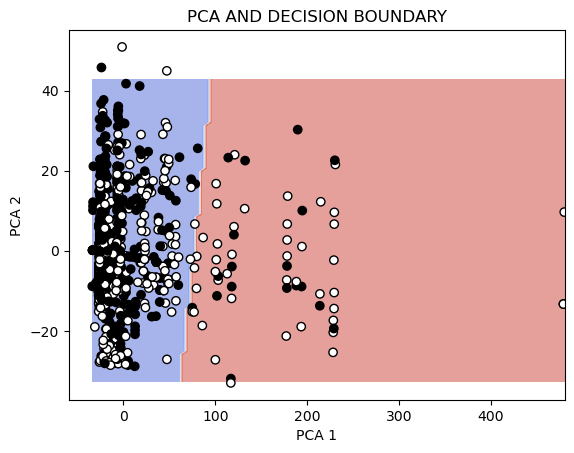

In [10]:
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt

pipeline.fit(X_train,y_train)


preprocessed_data = pipeline.named_steps['preprocessor'].transform(X_train)
preprocessed_data_test = pipeline.named_steps['preprocessor'].transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(preprocessed_data)
X_test_pca = pca.fit_transform(preprocessed_data_test)

pca_model = SVC(C=0.001,kernel='linear',gamma='scale')
pca_model.fit(X_train_pca,y_train)

disp = DecisionBoundaryDisplay.from_estimator(pca_model, 
                                              X_test_pca, 
                                              response_method="predict",
                                              xlabel= "PCA 1", ylabel="PCA 2",
                                              alpha=0.5, 
                                              cmap=plt.cm.coolwarm)

disp.ax_.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                 c=y_train, edgecolor="k",
                 cmap=plt.cm.coolwarm)

plt.title(f"PCA AND DECISION BOUNDARY")

plt.show()

